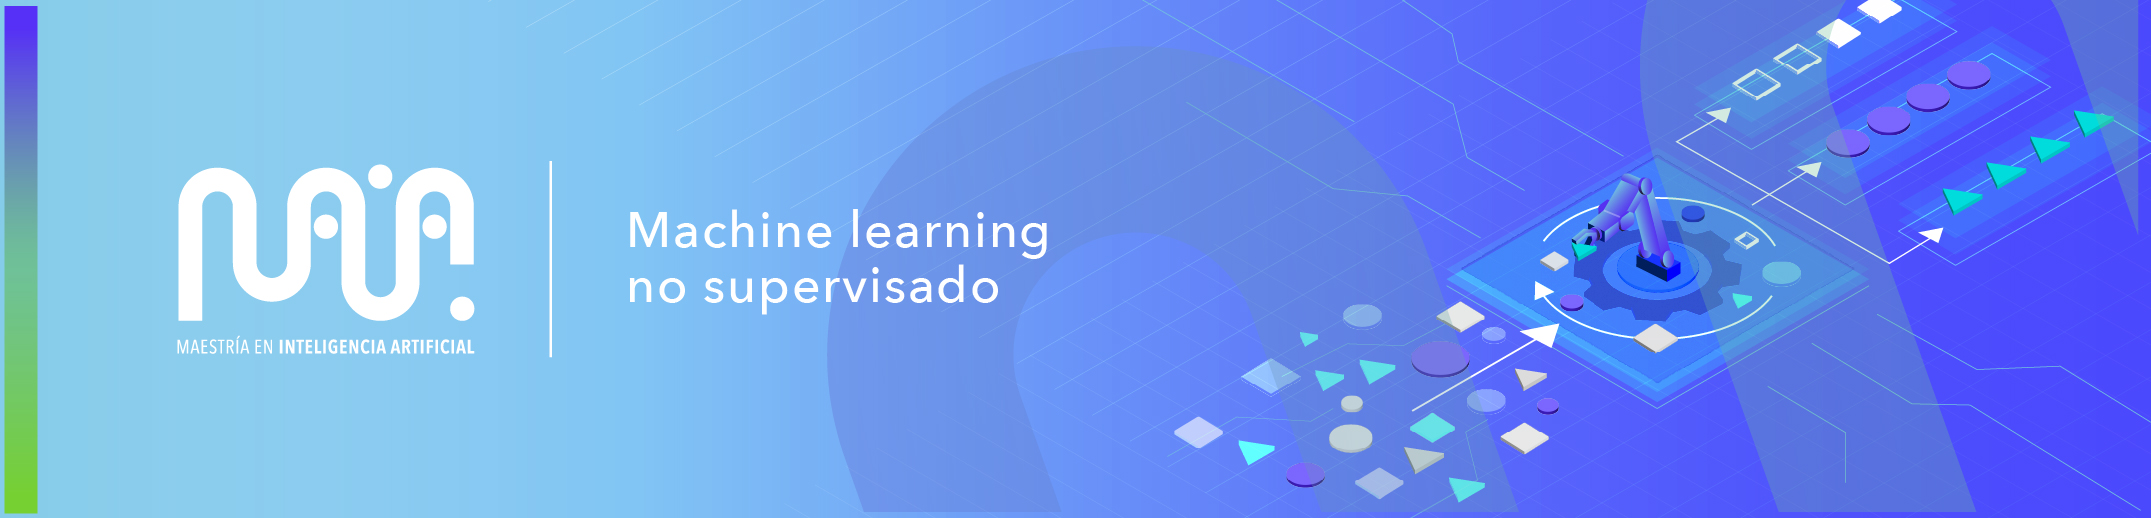

# Problema práctico de la semana. Agrupación con KMeans y KMedoides e interpretación.

En este notebook verás una posible solución para el problema planteado utilizando los algoritmos KMeans y KMedoides. En particular, se cargará el conjunto de datos de segmentación de clientes procesado, y se mostrará la selección del hiperparámetro _k_ mediante el método del codo y el método de la silueta, interpretando los grupos del mejor modelo de agrupación resultante. En este sentido, veremos cómo realizar los siguientes procesos:

1. [Importar las librerías necesarias.](#1.-Importación-de-librerías-requeridas)
2. [Cargar el conjunto de datos de clientes.](#2.-Carga-de-datos)
3. [Realizar la agrupación usando los algoritmos KMeans y KMedoides.](#3.-Agrupación-con-KMeans-y-KMedoides)
4. [Interpretar los grupos resultantes.](#4.-Interpretación-de-los-grupos-resultantes)

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `numpy`, `matplotlib` y `scikit-learn`, así como la librería `sklearn_extra` para usar el algoritmo KMedoides (recuerda que si no has instalado la librería `sklearn_extra`debes hacerlo con `pip install scikit-learn-extra`):

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import joblib

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn_extra.cluster  import KMedoids
from sklearn.preprocessing import RobustScaler

## 2. Carga de datos

Como ya realizamos el procesamiento de datos anteriormente, solo tenemos que cargar nuestro conjunto usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data = pd.read_csv('data/Customer_Data_processed.csv', sep=',')
data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.706404,-0.096365,-0.360201,0.259907,-0.461199,-0.149359,-0.022136,-0.174313,0.721663,-0.943983,0.666667,-0.831933,0.674718,-0.001738,-0.356376,0.804098,-0.333333
1,0.075457,0.855976,0.554035,-0.911285,0.513621,0.746618,0.527013,-0.713970,0.159355,0.170412,-0.148148,-0.168067,0.242031,-0.841000,0.543236,-0.186756,0.333333
2,-0.767884,-0.224286,-0.277162,0.260246,-0.482262,-0.497470,-0.176037,0.183976,0.591893,-0.901636,-0.148148,-0.781513,-0.726723,0.160748,-0.394892,0.941998,-0.333333
3,0.191021,0.918701,0.889008,-0.851900,0.548651,0.818332,0.857051,-0.630162,-0.358285,0.198539,0.222222,0.050420,-0.194601,-0.904274,0.506117,-0.103139,0.666667
4,0.045087,0.706886,0.767803,-0.894535,0.556992,0.514631,0.898597,-0.478037,-0.269085,0.028564,0.777778,0.336134,-0.140526,-0.789773,0.360487,-0.071436,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,-0.624868,-0.125160,-0.301170,0.176413,-0.478302,-0.307974,-0.094401,0.014804,0.744291,-0.948332,-0.259259,-0.630252,0.964277,0.162969,-0.532440,0.906252,-0.333333
8632,0.070804,0.670512,0.591432,-0.925578,0.526027,0.594241,0.556441,-0.648191,-0.207554,-0.015968,0.481481,-0.050420,-0.904121,-0.880302,0.684994,-0.262969,0.666667
8633,0.470182,-0.204803,-2.095708,0.055416,0.026279,-0.168947,-0.216634,0.535351,0.279126,0.145210,-1.148148,-0.210084,-4.189564,0.099623,0.228162,-0.633106,0.000000
8634,0.371711,-0.331669,-1.472036,0.028111,0.101562,-0.222853,-0.146259,0.684382,0.003808,0.138643,-0.777778,0.016807,-3.166931,0.000306,0.060401,-0.720327,0.000000


Además, cargaremos el objeto `robust_scaler` almacenado en el notebook anterior:

In [3]:
robust_scaler = joblib.load('obj/robust_scaler.joblib')
type(robust_scaler)

sklearn.preprocessing._data.RobustScaler

## 3. Agrupación con KMeans y KMedoides

Primero definiremos las funciones `elbow_plot()` y `silhouette_plot()` para realizar la selección del hiperparámetro _k_:

In [4]:
def elbow_plot(X, model, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, metric='manhattan', random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el valor de inercia
        inertias.append(model_k.inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clústeres')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

Agregaremos la línea `display(pd.DataFrame({'K': range(k_min,k_max+1), 'Coeficiente': scores}))` para mostrar los valores específicos del coeficiente de la silueta. Esto nos brindará información más específica para la selección del hiperparámetro _k_:

In [5]:
def silhouette_plot(X, model, k_min=2, k_max=5):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)
    # Mostramos los valores de los coeficientes
    display(pd.DataFrame({'K': range(k_min,k_max+1), 'Coeficiente': scores}))
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clústeres')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

### Método del codo

Como primer método de selección del hiperparámetro _k_, utilizaremos la función `elbow_plot()` para graficar la inercia contra el número de clústeres. Realizaremos el mismo proceso para los dos algoritmos, graficando en el rango [2,15]:

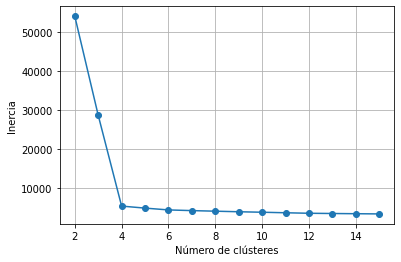

In [6]:
elbow_plot(data, "kmeans", 2, 15)

Para KMeans podemos observar una disminución considerable en la inercia desde `k=3`. Sin embargo, si tenemos en cuenta la definición del método del codo, el valor óptimo de _k_ es **4**, ya que después de este es cuando se tiene un comportamiento aproximadamente lineal.

Ahora veremos cómo se comporta el conjunto para KMedoides:

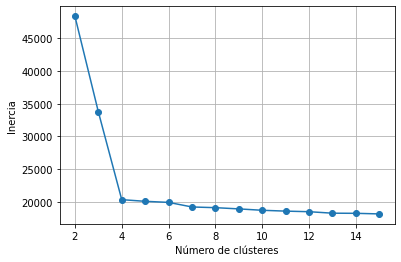

In [7]:
elbow_plot(data, "kmedoids", 2, 15)

Con KMedoides se observa un comportamiento similar pues se puede observar un codo en `k=4`. 

### Método de la silueta

Utilizaremos también el método de la silueta para comparar directamente los dos algoritmos. Primero revisaremos cómo se comporta KMeans:

,K,Coeficiente
0,2,0.465620
1,3,0.612184
2,4,0.751371
3,5,0.542604
4,6,0.342710
5,7,0.260112
6,8,0.235305
7,9,0.172292
8,10,0.209044


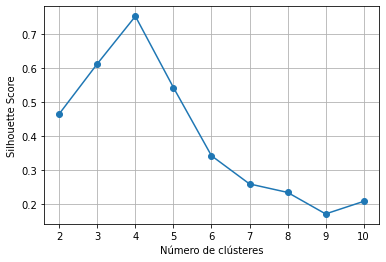

In [8]:
silhouette_plot(data, "kmeans", 2, 10)

Continuando con lo que observamos utilizando el método del codo, el valor más alto del coeficiente de la silueta se presenta en `k=4`, llegando a un valor de 0.751371. Por otro lado, tenemos el siguiente comportamiento para KMedoides:

,K,Coeficiente
0,2,0.435649
1,3,0.578283
2,4,0.751371
3,5,0.522388
4,6,0.521659
5,7,0.501052
6,8,0.503845
7,9,0.499031
8,10,0.499621


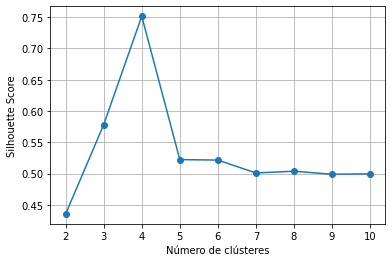

In [9]:
silhouette_plot(data, "kmedoids", 2, 10)

Con KMedoides el mejor valor de _k_ se presenta también para `k=4`, con un valor de 0.751371. En este punto podemos argumentar que el mejor valor es `k=4`, y tanto KMeans como KMedoides son soluciones válidas.

## 4. Interpretación de los grupos resultantes

Con el análisis realizado para los dos algoritmos, sabemos el mejor valor de _k_, pero podemos utilizar cualquiera de los dos algoritmos para entrenar el mejor modelo. Como en este conjunto de datos todas las variables son numéricas, utilizaremos KMeans con `k=4`:

In [10]:
mejor_modelo = KMeans(n_clusters=4, random_state=0)
mejor_modelo.fit(data)

C:\Users\ndiaz\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=0)

Como análisis inicial, veremos la distribución de nuestros clientes con respecto a los cuatro grupos:

([<matplotlib.axis.XTick at 0x27a21d193a0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

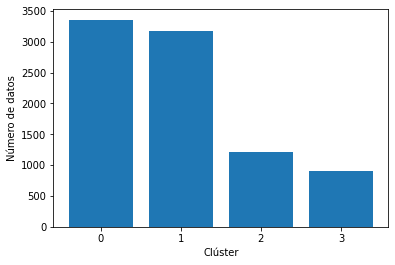

In [11]:
labels = mejor_modelo.labels_
indexes, values = np.unique(labels, return_counts=True)
rects = plt.bar(indexes, values)
plt.xlabel('Clúster')
plt.ylabel('Número de datos')
plt.xticks(indexes)

Tenemos dos clústeres con más de 3000 datos, mientras que el clúster más pequeño solo tiene aproximadamente 900 clientes. Específicamente, podemos tener el número exacto de clientes en cada clúster accediendo a `indexes` y `values`:

In [12]:
{indexes[i]: values[i] for i in range(len(indexes))}

{0: 3356, 1: 3171, 2: 1206, 3: 903}

Para darnos una idea de cómo es cada cliente, vamos a obtener los centroides de cada grupo. En este punto haremos uso del objeto `robust_scaler` que cargamos inicialmente:

In [13]:
centroids_array = mejor_modelo.cluster_centers_
centroids_original = robust_scaler.inverse_transform(centroids_array)
centroids = pd.DataFrame(centroids_original, columns=data.columns)
centroids

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,13252.473365,0.775734,40656.032468,6132.662569,19462.256862,37231.770958,0.797725,0.227979,0.534946,0.990844,92.581049,206.825089,14534.185216,8548.249145,58146.385395,0.363650,9.859058
1,4451.126307,0.193317,29747.057865,35140.273594,3313.474410,11129.239338,0.425684,0.567289,0.838328,0.201070,80.939451,85.725008,15523.980921,24623.728686,32951.234081,0.837494,6.363923
2,16285.111896,0.181718,7392.765979,31408.672313,10932.107057,21763.987743,0.513926,0.702533,0.642639,0.990455,52.631841,166.533167,4386.390604,20649.435423,55187.141515,0.149516,7.826700
3,3105.917172,0.583910,26323.521692,31054.681489,10485.803990,9355.103901,0.206352,0.797868,0.178405,1.314128,29.837209,284.805094,26109.000090,43726.525314,17429.339551,0.723273,10.598007


Podemos interpretar los centroides de la siguiente forma:

- **Clúster 0 (3356 clientes):** este segmento se caracteriza por tener el segundo balance más alto, con una frecuencia de actualización del balance muy alta. Este grupo se caracteriza por realizar muchas compras (variable `PURCHASES`) y con mucha frecuencia (variable `PURCHASES_FREQUENCY`), aunque se caracterizan por realizar pagos a cuotas con media frecuencia (variable `PURCHASES_INSTALLMENTS_FREQUENCY`). Además, este segmento tiene un porcentaje de pago de su tarjeta bajo (variable `PRC_FULL_PAYMENT`).

- **Clúster 1 (3171 clientes):** este segmento de clientes presenta un balance bajo, así como una frecuencia de actualización del balance baja, aunque realizan una cantidad moderada de compras con frecuencia media. La principal característica de estos clientes es que tienen una baja cantidad de compras a cuotas, además de un porcentaje alto del pago de sus tarjetas.

- **Clúster 2 (1206 clientes):** este segmento de clientes se caracteriza por tener el balance más alto, aunque con la frecuencia de actualización más baja. El límite de crédito es el más bajo entre los segmentos, con una cantidad de pagos media y un porcentaje bajo de pago total de su tarjeta.

- **Clúster 3 (903 clientes):** este segmento presenta el balance más bajo, así como la menor cantidad de compras. Tienen la menor cantidad de avances de efectivo (variable `CASH_ADVANCE`), con una frecuencia alta de pagos de los avances que solicitan (variable `CASH_ADVANCE_FREQUENCY`). También son los clientes que realizan compras en un solo pago con mayor frecuencia (variable `ONEOFF_PURCHASES_FREQUENCY`) y tienen un alto porcentaje de pago de su tarjeta.

## Cierre

En este notebook viste una posible solución al problema de agrupación planteado utilizando los algoritmos KMeans y KMedoides. En particular, observaste la selección del hiperparámetro _k_ mediante el método del codo y el método de la silueta, prefiriendo utilizar KMeans. Ten en cuenta que la interpretación de los centroides puede ser subjetiva, por lo que las conclusiones a las que se llegaron en este notebook no deben ser tomadas como las únicas posibles.

---
*Creado por: Nicolás Díaz*  
*Revisado por: Haydemar Nuñez*  
*Versión de: Diciembre 8, 2023*  
*Universidad de los Andes*   